## Summary
By bringing together a couple different datasets (DataKind dataset, 990 descriptions dataset, SGD text documents) we get 24000 instances of text labeled with the appropriate SDGs. Off-the-shelf SVMs give reasonably good performance, so with more data and some tuning you could expect passable performance.

Here's a list of ideas for improvement, ordered most-to-least important. Getting more data by far the best use of time.

- More data (Ion's dataset?!)
- More data for SDGs that are underrepresented in this set - there's very high class imbalance
- Tune models and diagnose for overfitting/underfitting, ROC scores
- Supervised ensemble
- Squeeze out some more performance with multilabel-specific algorithms and metrics (https://nickcdryan.wordpress.com/2017/01/23/multi-label-classification-a-guided-tour/) (Sorry for the plug)
- Ensemble with unsupervised approach like LDA or k-means 

## Import

In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics import coverage_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [14]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

import datetime
import string

%matplotlib inline

In [15]:
# !! 
#
# The following code hides warnings
# Since classes are imbalanced and we're using cross validation, often our folds won't contain a training
# example from every class and we'll get lots and lots of errors tellins us so during fitting
#
# !!

import warnings
warnings.filterwarnings('ignore')

## Mapping Dictionaries

In [16]:
SDG_dict = {1:"1: No Poverty", 
            2:"2: Zero Hunger",
            3:"3: Good Health and Well-being",
            4:"4: Quality Education",
            5:"5: Gender Equality",
            6:"6: Clean Water and Sanitation",
            7:"7: Affordable and Clean Energy",
            8:"8: Decent Work and Economic Growth",
            9:"9: Industry, Innovation, and Infrastructure",
            10:"10: Reduced Inequalities",
            11:"11: Sustainable Cities and Communities",
            12:"12: Responsible Consumption and Production",
            13:"13: Climate Action",
            14:"14: Life Below Water",
            15:"15: Life on Land",
            16:"16: Peace, Justice, and Strong Institutions",
            17:"17: Partnerships for the Goals"}

In [17]:
# NTEE to SDG
NTEE_dict = {'B':[4],
            'C':[12, 13, 14, 15, 16],
            'F':[3],
            'G':[3],
            'H':[3],
            'J':[8],
            'K':[2],
            'L':[1]}

## Load and process datasets for modeling
We'll pull together a couple of different datasets to generate one dataset (df_data) of text descriptions and SDGs associated with them

- `manula_datakind_labels.csv` contains ~350 labeled SDG examples
- `Sample_Program_Service_Data.csv` contains thousands of examples with EINs
- `NTEE_EINs_EOBMF.csv` maps between nonprofit-descriptions_2016.csv EINs and NTEE taxonomy
- NTEE_dict is a manual mapping between some NTEEs and SDGs
- `goals.txt` contains SDGs and their descriptions

In [20]:
# load manula datakind set, split labels to distinct elements
df_lab = pd.read_csv('manula_datakind_labels.csv')
df_lab = df_lab[['text', 'SDGs']]
for i in range(len(df_lab)):
    try: 
        df_lab['SDGs'][i] = df_lab['SDGs'][i].strip().split(", ")
    except:
        continue

# take valid rows and map string type SDGs to integer type        
df_lab = df_lab[df_lab['SDGs'].apply(type)==list]
df_lab['SDGs'] = df_lab['SDGs'].map(lambda x: list(map(int,x)))
df_lab.head()

,text,SDGs
0,Continue to work towards achieving gender equa...,[5]
1,"Ensure access to education, employment, health...","[8, 3, 4, 10]"
2,Enhance cooperation at the regional and intern...,"[1, 3, 2, 6]"
3,Continue the efforts undertaken by the Governm...,"[9, 16]"
4,"Improve equal access to the legal aid system, ...","[1, 10, 16]"


In [21]:
# NTEE file import to DF
df_ntee = pd.read_csv('NTEE_EINs_EOBMF.csv')

In [22]:
# split NTEE letter and code
letter = []
code = []
for i in df_ntee['NTEE'].values:
    try:
        letter.append(i[0])
        code.append(i[1:-1])
    except:
        letter.append('Null')
        code.append('Null')

df_ntee['letter'], df_ntee['code'] = letter, code

In [23]:
# process NTEE codes to integer value
to_int = []
for i in df_ntee['EIN'].values:
    try:
        to_int.append(int(i.replace("-", "")))
    except:
        to_int.append(i)

df_ntee.drop('EIN', axis=1)
df_ntee['EIN'] = to_int

In [24]:
df_ntee.head()

,EIN,NTEE,letter,code
0,19818,NaN,Null,Null
1,29215,NaN,Null,Null
2,587764,X21,X,2
3,635913,X21,X,2
4,765634,X20,X,2


In [36]:
df_desc = pd.read_csv("../Sample_Program_Service_Data.csv", encoding="Windows-1252")
df_desc = df_desc.rename(columns={"NAME": "orgName", "DBA": "activityDesc", "MISSION": "missionDesc"})


In [37]:
# import descriptions file, combine useful text features into one text column
df_text = df_desc[['EIN', 'orgName','activityDesc','missionDesc','proj1Desc']]
df_text["text"] = df_text["orgName"] + df_text["activityDesc"] + df_text["missionDesc"] + df_text["proj1Desc"]

In [38]:
# filter for text values only
df_text = df_text[df_text['text'].apply(type)==str]

In [42]:
# join descriptions file with EIN dataset to map descriptions to NTEEs
df_merged = pd.merge(df_text, df_ntee, on='EIN', how='inner')
df_merged

,EIN,orgName,activityDesc,missionDesc,proj1Desc,text,NTEE,letter,code
0,100000085,GREATER ROCHESTER ENTERPRISE,FOUNDATION INC,GENERATE CONTRIBUTIONS TO HELP SUPPORT THE ACT...,GENERATE CONTRIBUTIONS TO HELP SUPPORT THE COM...,GREATER ROCHESTER ENTERPRISEFOUNDATION INCGENE...,S31,S,3
1,100003552,ACTS COMMUNITY DEVELOPMENT,AKA ACTS COMMUNITY DEVELOPMENT CORP,DEVELOPMENT OF THE COMMUNITY THROUGH SMALL BUS...,"""ACTS COMMUNITY DEVELOPMENT (ACD) GREW OUT OF ...",ACTS COMMUNITY DEVELOPMENTAKA ACTS COMMUNITY D...,S20,S,2
2,100005187,AMERICAN AMISTAD FOUNDATION INC,C/O WILLIAM P WOLFE,MEDICAL CARE AND EDUCATIONAL ASSISTANCE,"PROVIDE FINANCIAL, MEDICAL AND PERSONAL ASSIST...",AMERICAN AMISTAD FOUNDATION INCC/O WILLIAM P W...,E99,E,9
3,10199596,THE WOMEN'S BOARD OF THE MAINE,GENERAL HOSPITAL,THE WOMEN'S BOARD PERFORMS THE FOLLOWING FUNCT...,"THE WOMEN'S BOARD OPERATES THE PAVILION GRILL,...",THE WOMEN'S BOARD OF THE MAINEGENERAL HOSPITAL...,NaN,Null,Null
4,10211485,BANGOR YOUNG MEN'S CHRISTIAN,ASSOCIATION,THE BANGOR YMCA IS A COMMUNITY LEADER IN SUPPO...,"""EVERY DAY, THE BANGOR YMCA GIVES OUR COMMUNIT...",BANGOR YOUNG MEN'S CHRISTIANASSOCIATIONTHE BAN...,P270,P,27
...,...,...,...,...,...,...,...,...,...
10046,990329524,MANOA HERITAGE CENTER,FKA MANOA VALLEY CULTURAL HERITAGE FOUND,THE MANOA HERITAGE CENTER'S MISSION IS TO PROM...,EDUCATIONAL PROGRAMS AND ACTIVITIES INCLUDING ...,MANOA HERITAGE CENTERFKA MANOA VALLEY CULTURAL...,A80,A,8
10047,990351832,WAIKIKI BUSINESS IMPROVEMENT,DISTRICT ASSOCIATION,THE WAIKIKI BUSINESS IMPROVEMENT DISTRICT ASSO...,"THE STREETSCAPE MAINTENANCE PROGRAM, LAUNCHED ...",WAIKIKI BUSINESS IMPROVEMENTDISTRICT ASSOCIATI...,S20,S,2
10048,990354544,One Achord Guitar Lessons Inc,dba New Horizons Counseling,The organization provides counseling from one ...,Provided 5 treatment camps that changed the li...,One Achord Guitar Lessons Incdba New Horizons ...,A6C,A,6
10049,990354795,COMMUNITY BASED EDUCATION SUPPORT,SERVICES-FRIENDS OF CONNECTIONS,TO PROVIDE SUPPORT SERVICES AND INFRASTRUCTURE...,THE ORGANIZATION EXISTS TO PROVIDE SUPPORT SER...,COMMUNITY BASED EDUCATION SUPPORTSERVICES-FRIE...,B11,B,1


In [43]:
# map NTEEs to SDGs
sdg = []
for i in df_merged['letter'].values:
    try:
        sdg.append(NTEE_dict[i])
    except:
        sdg.append(0)

In [44]:
df_merged['SDGs'] = sdg
df_lab2 = df_merged[['text', 'SDGs']]
df_lab2 = df_lab2[df_lab2['SDGs']!=0]

In [45]:
df_lab2.head()

,text,SDGs
5,PINE TREE SOCIETY FOR HANDICAPPEDCHILDREN AND ...,[4]
6,PINE TREE SOCIETY FOR HANDICAPPEDCHILDREN AND ...,[4]
7,JESUP MEMORIAL LIBRARYC/O COSTON AND MCISAACPU...,[4]
10,TRUSTEES OF LEAVITT INSTITUTEC/O GEORGE RICHAR...,[4]
11,Kennebec Valley Mental Health CenterD/B/A Kenn...,[3]


In [46]:
# load goals.txt for a few more training examples
df_goals = pd.read_table('goals.txt', header=None)
df_goals.columns = ['text']
df_goals['SDGs'] = [[i] for i in range(1,18)]
df_lab3 = df_goals
df_lab3.head()

,text,SDGs
0,End poverty in all its forms everywhere . By ...,[1]
1,"End hunger, achieve food security and improved...",[2]
2,Ensure healthy lives and promote well-being fo...,[3]
3,Ensure inclusive and equitable quality educati...,[4]
4,Achieve gender equality and empower all women ...,[5]


In [47]:
# merge the datasets into one file for modeling
df_data = pd.concat([df_lab, df_lab2, df_lab3])

In [48]:
df_data.head()

,text,SDGs
0,Continue to work towards achieving gender equa...,[5]
1,"Ensure access to education, employment, health...","[8, 3, 4, 10]"
2,Enhance cooperation at the regional and intern...,"[1, 3, 2, 6]"
3,Continue the efforts undertaken by the Governm...,"[9, 16]"
4,"Improve equal access to the legal aid system, ...","[1, 10, 16]"


In [49]:
# number of rows in our new dataset
len(df_data)

3333

In [50]:
df_data.to_csv('labeled_SDGs.csv', sep=',')

## Modeling
This is a multilabel problem, so we'll binarize labels and do binary relevance (one vs. rest) as a baseline.

In [51]:
# tf-idf for text features, tokenizing with nltk. To improve performance, lemmatize (or stem) and tune max_df
tfidf = TfidfVectorizer( max_df=.2, stop_words = text.ENGLISH_STOP_WORDS.union(string.punctuation),
                             tokenizer = word_tokenize)
X = tfidf.fit_transform(df_data.text)
y = df_data.SDGs
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

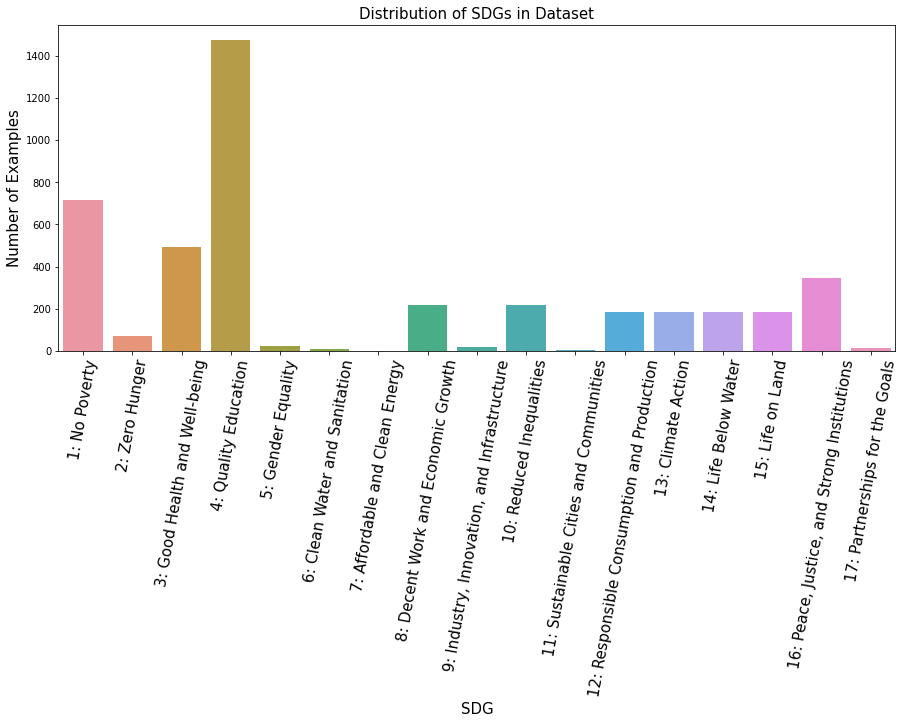

In [52]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=80, fontsize = 15)
plt.title('Distribution of SDGs in Dataset', fontsize = 15)
plt.ylabel('Number of Examples', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], y.sum(axis=0))

In [53]:
# label cardinality is average number of labels per training example
df_data['SDGs'].apply(len).mean()

1.3033303330333033

Some sklearn classes can handle multilabel, otherwise you have to pass it into OneVsRestClassifier

In [54]:
dt = DecisionTreeClassifier()
mnb = OneVsRestClassifier(MultinomialNB())
rf = RandomForestClassifier()
svm = OneVsRestClassifier(LinearSVC())
knn = KNeighborsClassifier()
#nn = MLPClassifier(activation='relu', solver ='adam', random_state=42,  
                  #hidden_layer_sizes=(175,), max_iter=200,) # takes a long time and needs tuning

classifiers = {'tree': dt, 'naive bayes' :mnb, 'forest': rf, 'svm': svm, 'knn': knn}#, 'nn': nn}

In [58]:
def get_scores(metric):
    scores = dict()
    for clf_name, clf in classifiers.items():
        start = time.time()
        score = cross_val_score(clf, X, y, scoring = metric, cv=7)
        end = time.time()
        print(clf_name + " took %f seconds" % (end-start))
        scores[clf_name] = score
          
    return pd.DataFrame(scores)

tree took 7.328328 seconds
naive bayes took 0.444078 seconds
forest took 39.385557 seconds
svm took 0.984625 seconds
knn took 1.717600 seconds


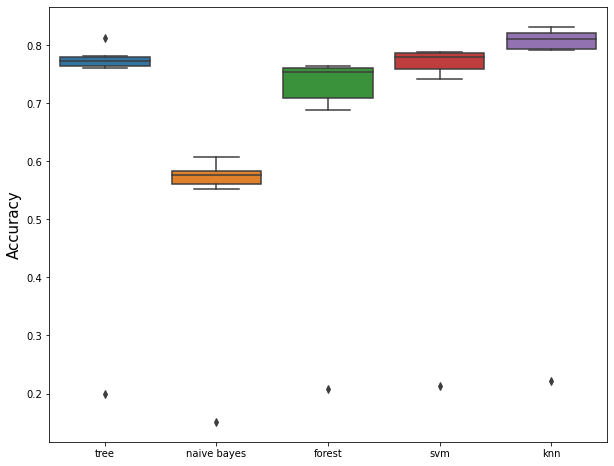

In [59]:
# accuracy is usually not a great metric for multilabel data - it only scores an exact match and gives no reward for 
# partial corectness. However, because label cardinality is only around 1.25 meaning we only have one or two labels 
# for most examples, accuracy is still an informative metric
plt.figure(figsize=(10,8))
plt.ylabel('Accuracy', fontsize=15)
sns.boxplot(data=get_scores('accuracy'))

Not bad. For comparison, using only the ~300 sample DataKind dataset yields a top performance with SVM around .42.
<p> Blue diamonds are outliers, so very high variance in accuracy for (strangely) exactly one of the folds...something's amiss, but we'll deal with it later.

tree took 7.189638 seconds
naive bayes took 0.366582 seconds
forest took 42.026239 seconds
svm took 1.197063 seconds
knn took 1.849747 seconds


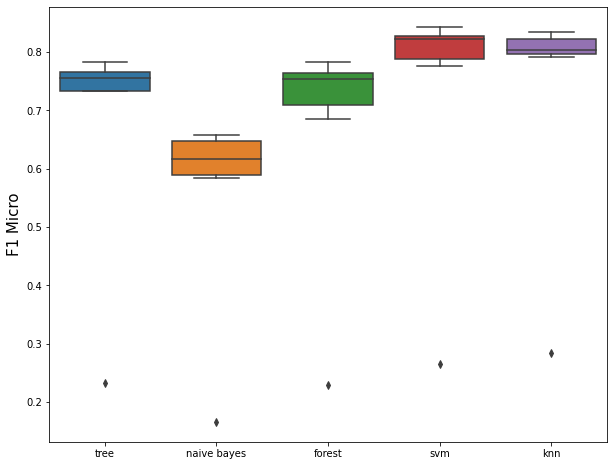

In [60]:
plt.figure(figsize=(10,8))
plt.ylabel('F1 Micro', fontsize=15)
sns.boxplot(data=get_scores('f1_micro'))

Improvement is OK. For comparison, using only the ~300 sample DataKind dataset yields a top performance with SVM around .71

## Let's try to predict the SDGs of text input with different classifiers

In [61]:
def predict_SDG(text, model):
    test = tfidf.transform([text])
    model.fit(X,y)
    preds = model.predict(test)
    SDGs= zip(preds[0], [SDG_dict[int(i)] for i in list(mlb.classes_)])
    return [desc for num,desc in SDGs if num==1]

In [62]:
acore = "ACORE is a national non-profit organization dedicated to advancing the renewable energy sector through market development, policy changes, and financial innovation. With a savvy staff of experts, fifteen years of experience promoting renewable energy and hundreds of member companies, non-profits, and other organizations from across the spectrum of renewable energy technologies, consumers, and investors, ACORE is uniquely well-positioned to strategically promote the policies and financial structures essential to renewable energy growth. The organization’s annual conferences in Washington, D.C., New York and San Francisco set the industry standard in providing important venues for key leaders to meet, discuss recent developments, and hear the latest from senior government officials and seasoned experts. ACORE's membership spans all constituencies in the renewable energy sector, including developers, manufacturers, providers of smart grid technologies, financial institutions, corporate end-users, professional service providers, educators, and allied non-profit groups. ACORE accomplishes much of its work by convening leaders in each of these constituencies, publishing research and analysis, advocating for key policies with Federal and state legislators and agency officials, facilitating communications among our members, and media outreach."

In [63]:
predict_SDG(acore, dt)

['12: Responsible Consumption and Production',
 '13: Climate Action',
 '14: Life Below Water',
 '15: Life on Land',
 '16: Peace, Justice, and Strong Institutions']

The decision tree model does OK, but there would ideally be marked false positives. The best classification would have been SDG 13 and SDG 7: Clean Energy, since ACORE is about renewable energy. The fact that we have a few false positives means that ACORE either has a very generic description, or our model features aren't exclusive enough -> we might try messing with features like the df_max param in tfidf. 
<p>As you might expect, the model will only perform well for the classes for which it has a decent amount of data. There were almost 0 examples of SDG 7: Clean Energy, so no chance that we would get a correct prediction.

In [64]:
msfgoals = "Médecins Sans Frontières is a private, international association. The association is made up mainly of doctors and health sector workers and is also open to all other professions which might help in achieving its aims. All of its members agree to honour the following principles: Médecins Sans Frontières provides assistance to populations in distress, to victims of natural or man-made disasters and to victims of armed conflict. They do so irrespective of race, religion, creed or political convictions. Médecins Sans Frontières observes neutrality and impartiality in the name of universal medical ethics and the right to humanitarian assistance and claims full and unhindered freedom in the exercise of its functions. Members undertake to respect their professional code of ethics and maintain complete independence from all political, economic or religious powers. As volunteers, members understand the risks and dangers of the missions they carry out and make no claim for themselves or their assigns for any form of compensation other than that which the association might be able to afford them."

In [65]:
predict_SDG(msfgoals, dt)

['12: Responsible Consumption and Production',
 '13: Climate Action',
 '14: Life Below Water',
 '15: Life on Land',
 '16: Peace, Justice, and Strong Institutions']

The best classification for msfgoals would probably be SDG 3. Decision tree gives a false positive, while... 

In [66]:
predict_SDG(msfgoals, knn)

[]

...KNN gets it right. SVM and random forest returns 0 results. 

## Evaluation

In [67]:
# 80/20 train test split
# TODO: shuffle rows before X and y are split
train_split = int(X.shape[0]*.8)
svm.fit(X[:train_split],y[:train_split])
y_pred = svm.predict(X[(train_split+1):])
y_true = y[(train_split+1):]

In [68]:
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(y_true,y_pred)

0.7819643172584354

In [69]:
true_predicted_diff = (y_true.sum(axis=0)-y_pred.sum(axis=0))
true_predicted_diff_norm = true_predicted_diff/y_true.sum(axis=0)

Difference ratio between true and predicted labels. Score of 0 indicates that there are either no wrong predictions or the false positives and false negatives cancel out.


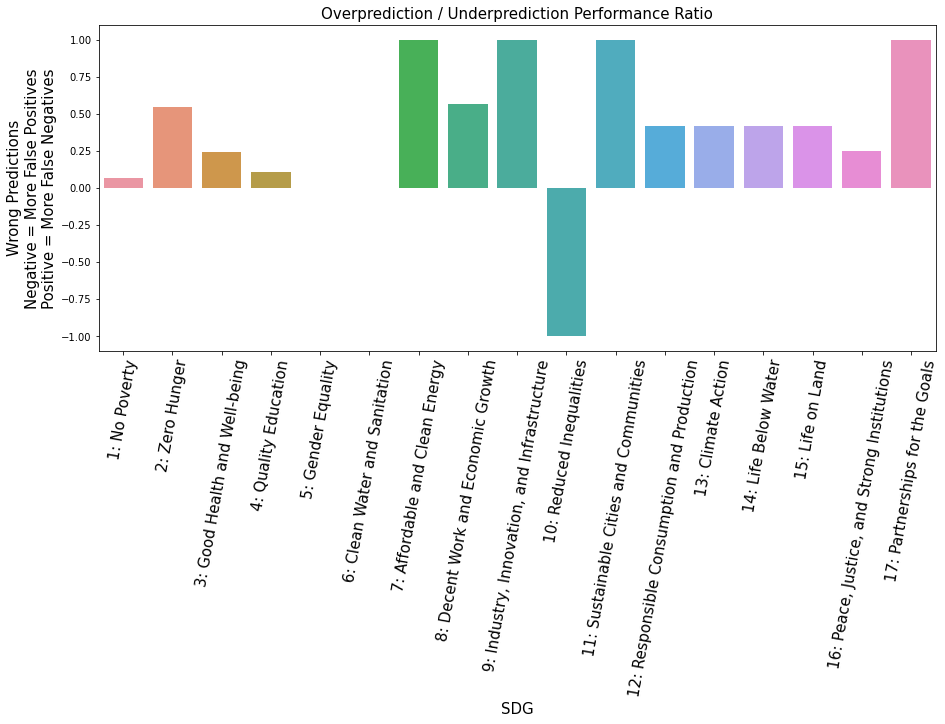

In [72]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=80, fontsize = 15)
plt.title('Overprediction / Underprediction Performance Ratio', fontsize = 15)
plt.ylabel('Wrong Predictions\nNegative = More False Positives\nPositive = More False Negatives', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], true_predicted_diff_norm)
print("Difference ratio between true and predicted labels. Score of 0 indicates that there are either no wrong predictions or the false positives and false negatives cancel out.")

A lot of SDGs classes are misclassified 100% of the time. If you recall the distribution of SDGs in the dataset (below), this makes sense because there are large class imbalances and some of these SDGs only appear once. Confusion matrices at bottom confirm this. 
<p>For the data we do have, it looks like SVM is giving more false negatives than false positives -> isn't sensitive enough. Worth exploring how different ensemble candidate models perform on this kind of quasi-ROC score basis if we want to adjust classification thresholds.

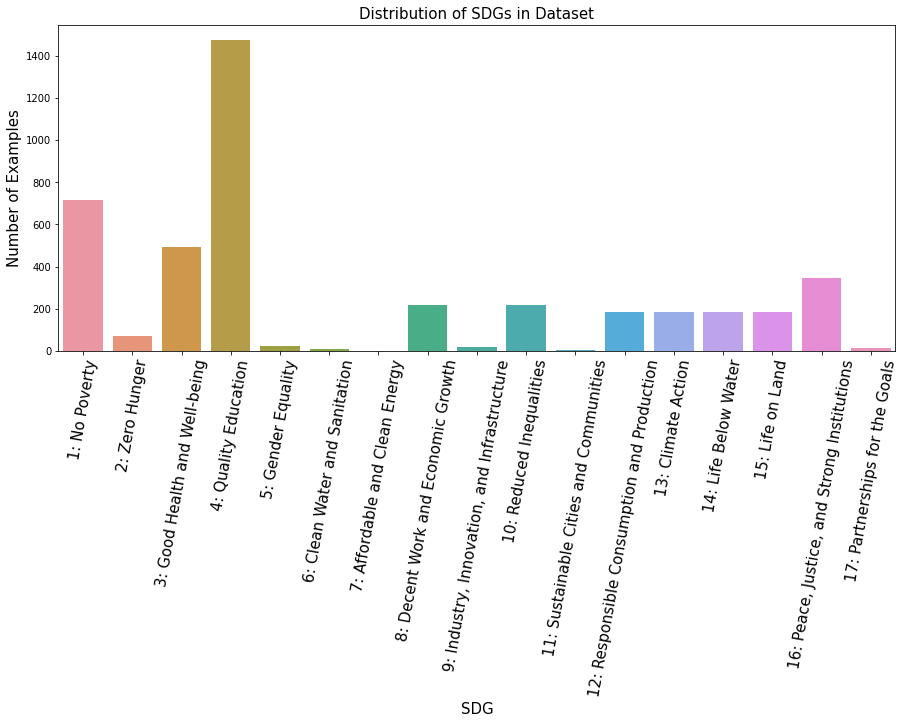

In [73]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=80, fontsize = 15)
plt.title('Distribution of SDGs in Dataset', fontsize = 15)
plt.ylabel('Number of Examples', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], y.sum(axis=0))

In [74]:
# plot confusion matrix 
def plot_confusion_matrix(cm_normalized, i):
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    title = "SDG "+ SDG_dict[int(mlb.classes_[i])]+ "\nNumber of Occurences = %i" % y_true[:,i].sum(axis=0)
    plt.title(title, fontsize=17)
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()

Confusion matrix:
 [[514   5]
 [ 15 132]]


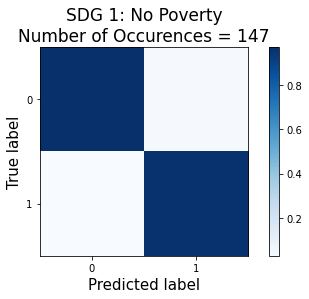

Confusion matrix:
 [[655   0]
 [  6   5]]


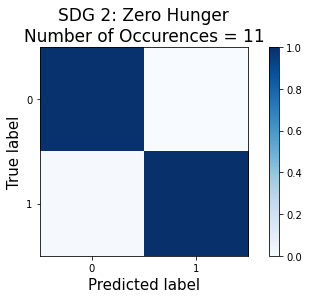

Confusion matrix:
 [[548   9]
 [ 35  74]]


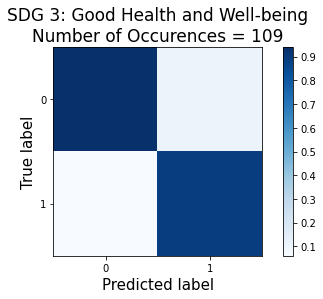

Confusion matrix:
 [[359  11]
 [ 42 254]]


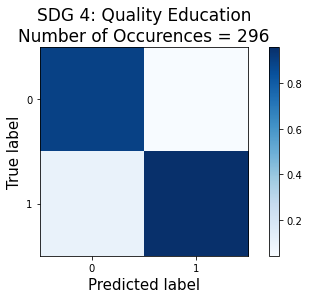

Confusion matrix:
 [[665   0]
 [  0   1]]


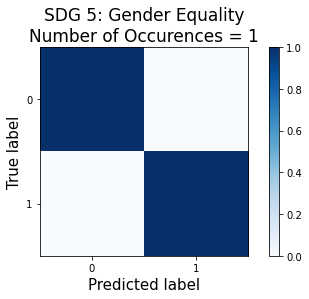

Confusion matrix:
 [[665   0]
 [  0   1]]


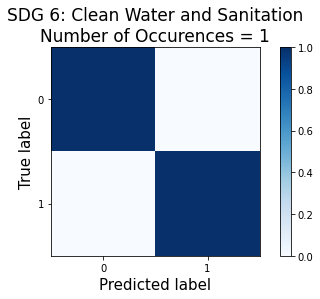

Confusion matrix:
 [[665   0]
 [  1   0]]


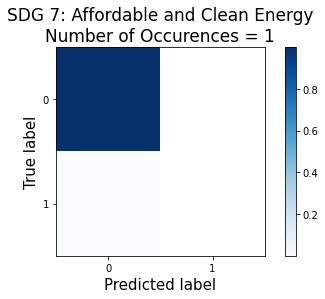

Confusion matrix:
 [[625   2]
 [ 24  15]]


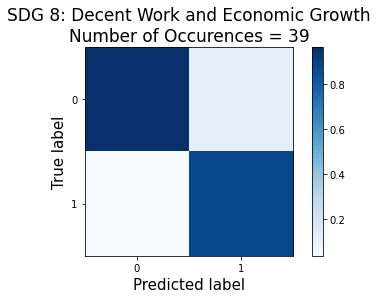

Confusion matrix:
 [[665   0]
 [  1   0]]


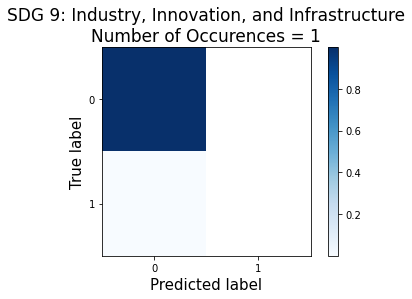

Confusion matrix:
 [[663   2]
 [  1   0]]


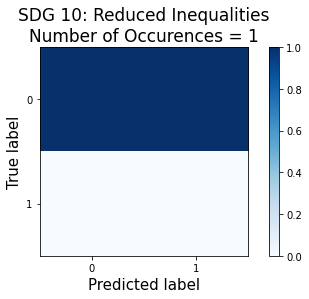

Confusion matrix:
 [[665   0]
 [  1   0]]


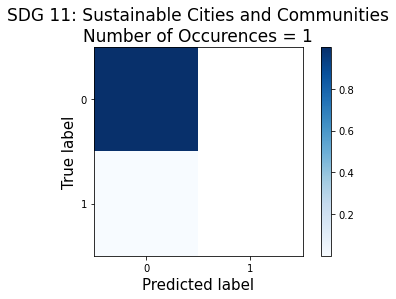

Confusion matrix:
 [[606   7]
 [ 29  24]]


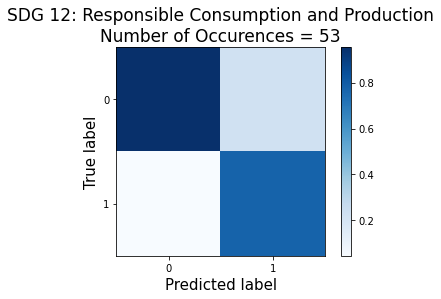

Confusion matrix:
 [[606   7]
 [ 29  24]]


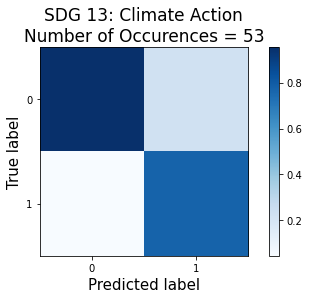

Confusion matrix:
 [[607   6]
 [ 28  25]]


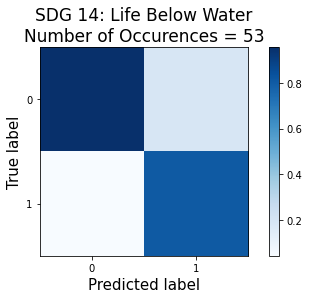

Confusion matrix:
 [[607   6]
 [ 28  25]]


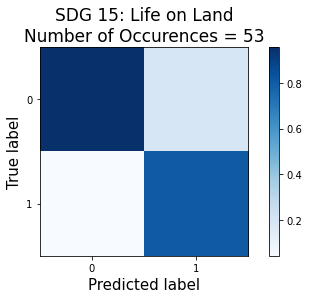

Confusion matrix:
 [[602  11]
 [ 24  29]]


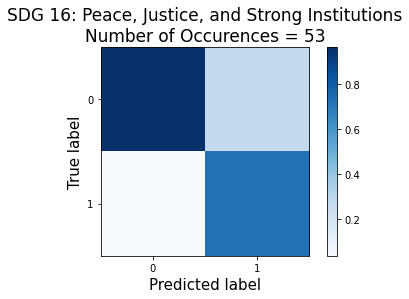

Confusion matrix:
 [[665   0]
 [  1   0]]


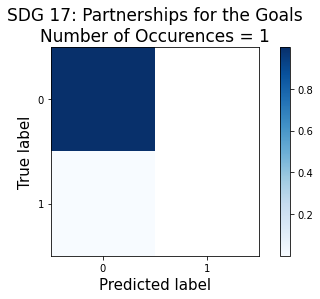

In [77]:
# For each SDG, output confusion matrix and normalized confusion viz
for ind, val in enumerate(mlb.classes_):
    cm = confusion_matrix(y_true[:,ind], y_pred[:,ind])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    print("Confusion matrix:\n", cm)
    plot_confusion_matrix(cm_normalized, ind)

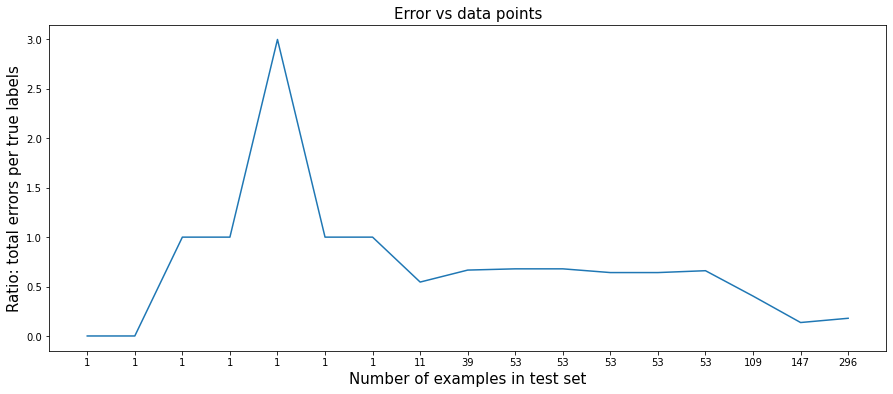

In [78]:
cm_error = []
occurences_list = []
graph_dict=dict()
for ind, val in enumerate(mlb.classes_):
    cm = confusion_matrix(y_true[:,ind], y_pred[:,ind])
    occurences = y_true[:,ind].sum(axis=0)
    cm_error.append((cm[0,1]+cm[1,0]) / occurences)
    occurences_list.append(occurences)

error_to_occurence = sorted(zip(cm_error, occurences_list), key=lambda x: x[1])
   
plt.figure(figsize=(15, 6))
plt.plot(range(1,18), [i for i,n in error_to_occurence])
plt.xticks(range(1,18), [n for i,n in error_to_occurence])
plt.title("Error vs data points", fontsize=15)
plt.ylabel("Ratio: total errors per true labels", fontsize=15)
plt.xlabel("Number of examples in test set", fontsize=15)
plt.show()